In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, log_loss
from sklearn import tree
from sklearn import linear_model
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import sys,os
import seaborn as sns
%matplotlib inline

In [84]:
#reading in data
training_data = pd.read_csv("/Users/vishaladdala/Desktop/TITANIC/dataset/train.csv")
training_data.sample(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
583,584,0,1,"Ross, Mr. John Hugo",male,36.0,0,0,13049,40.1250,A10,C
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q
403,404,0,3,"Hakkarainen, Mr. Pekka Pietari",male,28.0,1,0,STON/O2. 3101279,15.8500,NaN,S
620,621,0,3,"Yasbeck, Mr. Antoni",male,27.0,1,0,2659,14.4542,NaN,C
520,521,1,1,"Perreault, Miss. Anne",female,30.0,0,0,12749,93.5000,B73,S
354,355,0,3,"Yousif, Mr. Wazli",male,NaN,0,0,2647,7.2250,NaN,C
161,162,1,2,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Mi...",female,40.0,0,0,C.A. 33595,15.7500,NaN,S
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S


In [85]:
#training data statistics using .describe()
training_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [86]:
#Feature Transformations

In [87]:
#method to convert ages to bins called 'Unknown'for [-1,0], 'Baby' for [0-5],
#'Child' for [6-12], 'Teenager' for [13-19], 'Student' for [20-25], 'Young Adult' for [26-35], 'Adult' for [36-60],
#'Senior' for [61-100]
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 19, 25, 35, 60, 100)
    age_groups = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=age_groups)
    df.Age = categories
    return df

In [88]:
#method which simplifies the cabin feature by filling N/A values with 'N'
#also it takes only the first letter the cabin using splicing
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

In [89]:
#method to convert fares into bins using the numbers from .describe() statistics earlier
#the N/A values are filled with -0.5
def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

In [90]:
#Feature Extraction 
#the below method is used to extract two features from the Name column
#method to format the Name column to extract LName and NamePrefix
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    

In [91]:
#method to drop the features which we inconsider inconsequential
#we have selected ticket,Name,Embarked columns to be dropped due lack of variance or too many N/A values
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

In [92]:
#this method calls all the above transformation methods one by one and applies it on our dataframe
def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

In [93]:
#Now we proceed to proceed to apply the transformations on the training data
transformed_train = transform_features(training_data)
transformed_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [94]:
#as we can see above our training data now has :
#1. LName, NamePrefix instead of 'Name' which has been dropped
#2. 'Ticket', 'Name', 'Embarked' have been dropped 
#3. 'Fare', 'Age' have been converted into convenient bins

In [95]:
#Now as a next step, we need to remember that machine learning algorithms need all the input to be numerical values
#But as we can observe from above 'Sex', 'Age' , 'Fare', 'Cabin', 'Lname', 'NamePrefix' are in nominal(string) format
#Hence we need to convert these into numerical values

In [96]:
#Here we proceed to use LabelEncoder from sklearn preprocessing to achieve 
#Every column in numerical form
from sklearn import preprocessing
def encode_features(df_train):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
    return df_train
    
data_train = encode_features(transformed_train)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,73,17
1,2,1,1,0,0,1,0,3,2,136,18
2,3,1,3,0,7,0,0,0,7,251,14
3,4,1,1,0,7,1,0,3,2,198,18
4,5,0,3,1,7,0,0,1,7,11,17


In [97]:
#Now we proceed to test the various classifiers in Scikit-Learn to 
#see which classifiers works best on our data

In [98]:
#Below we are splitting up our training data into 80% training , 20% testing data 
# X contains all the columns except 'Survived' because that is the feature we predict
# Y consists only of the column 'Survived'
X = data_train.drop(['Survived'], axis=1)
Y = data_train.Survived
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(712, 10)
(179, 10)
(712,)
(179,)


In [99]:
#Our first classifier will be Decision Tree
from sklearn.tree import DecisionTreeClassifier
classifiers = {}
dtree = DecisionTreeClassifier()
dtree.fit(X_train, Y_train)
Y_pred =  dtree.predict(X_test)
print(confusion_matrix(Y_test,Y_pred))
print(accuracy_score(Y_test,Y_pred))
classifiers["Decision Tree"]=dtree

[[97 14]
 [24 44]]
0.787709497207


In [100]:
# Artifical Neural Network
clf = MLPClassifier()
clf.set_params(hidden_layer_sizes =(100,100), max_iter = 1000,alpha = 0.01, momentum = 0.7)
nn_clf = clf.fit(X_train,Y_train)
nn_predict = nn_clf.predict(X_test)
nn_acc = accuracy_score(Y_test,nn_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Artificial Nueral Network:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["NeuralNetwork"]=clf

Artificial Nueral Network:
0.531305611446  -  0.592749832327


In [101]:
#Deep Neural Network
clf = MLPClassifier()
clf.set_params(hidden_layer_sizes =(100,100,100,100), max_iter = 100,alpha = 0.3, momentum = 0.7,activation = "relu")
nn_clf = clf.fit(X_train,Y_train)
nn_predict = nn_clf.predict(X_test)
nn_acc = accuracy_score(Y_test,nn_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Deep Neural Network:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["DeepNeuralNetwork"]=clf

Deep Neural Network:
0.559239883747  -  0.516724793204


In [102]:
#Support Vector Machine
clf = svm.SVC()
clf.set_params(C = 100, kernel = "rbf")
svm_clf = clf.fit(X_train,Y_train)
svm_predict = svm_clf.predict(X_test)
svm_acc = accuracy_score(Y_test,svm_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Support Vector Machines:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["SupportVectorMachine"]=clf

Support Vector Machines:
0.618025933378  -  0.618025933378


In [103]:
#Multinomial Naive Bayes
clf = MultinomialNB()
clf.set_params(alpha = 0.1)
nb_clf = clf.fit(X_train,Y_train)
nb_predict = nb_clf.predict(X_test)
nb_acc = accuracy_score(Y_test,nb_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Multinomial Naive Bayes:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["MultinomialNaiveBayes"]=clf

Multinomial Naive Bayes:
0.53073384753  -  0.53073384753


In [104]:
#Logistic Regression
clf = LogisticRegression()
clf.set_params(C = 10, max_iter = 10)
lr_clf = clf.fit(X_train,Y_train)
lr_predict = lr_clf.predict(X_test)
lr_acc = accuracy_score(Y_test,lr_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Logistic Regression:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["LogisticRegression"]=clf

Logistic Regression:
0.714366756092  -  0.714366756092


In [105]:
#k-NN Classifier
clf = KNeighborsClassifier()
clf.set_params(n_neighbors= 5,leaf_size = 30)
knn_clf = clf.fit(X_train,Y_train)
knn_predict = knn_clf.predict(X_test)
knn_acc = accuracy_score(Y_test,knn_predict)
param =  knn_clf.get_params()
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("k-NN :")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["KNN"]=clf

k-NN :
0.565828303152  -  0.565828303152


In [106]:
#Random Forest Classifier
clf = RandomForestClassifier()
clf.set_params(n_estimators = 500, max_depth = 100)
rf_clf = clf.fit(X_train,Y_train)
rf_predict = rf_clf.predict(X_test)
rf_acc = accuracy_score(Y_test,rf_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Random Forest Classifier:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["RandomForest"]=clf

Random Forest Classifier:
0.832689470154  -  0.831241895819


In [107]:
#AdaBoost
clf = AdaBoostClassifier()
clf.set_params(n_estimators = 10, learning_rate = 0.5)
ada_clf = clf.fit(X_train,Y_train)
ada_predict = ada_clf.predict(X_test)
ada_acc = accuracy_score(Y_test,ada_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("AdaBoost:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["AdaBoost"]=clf

AdaBoost:
0.802991281019  -  0.802991281019


In [126]:
#Gradient Boosting Classifier
clf = GradientBoostingClassifier()
clf.set_params(n_estimators = 100,learning_rate = 0.25)
gb_clf = clf.fit(X_train,Y_train)
gb_predict = gb_clf.predict(X_test)
gb_acc = accuracy_score(Y_test,gb_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("GradientBoostingClassifier:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["GradientBoostingClassifier"]=clf



GradientBoostingClassifier:
0.825688016991  -  0.822791191594


In [109]:
#Perceptron
clf = linear_model.Perceptron()
#clf.set_params(max_iter = 1000,alpha = 0.01)
pt_clf = clf.fit(X_train,Y_train)
pt_predict = pt_clf.predict(X_test)
pt_acc = accuracy_score(Y_test,pt_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Perceptron:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["Perceptron"]=clf

Perceptron:
0.55364017438  -  0.55364017438


In [110]:
#Here we print the performance of the various classifiers
print ("accuracy","              ","F-score")
for clf in classifiers.values():
    accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
    f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
    for i in classifiers:
        if classifiers[i]== clf:
            print (i),
            break
    print ( " : ",accuracy.mean(), "  ",f_score.mean())
    

accuracy                F-score
Decision Tree
 :  0.760692488263    0.753827967807
NeuralNetwork
 :  0.512438520009    0.53620780237
DeepNeuralNetwork
 :  0.531324055444    0.588330538788
SupportVectorMachine
 :  0.618025933378    0.618025933378
MultinomialNaiveBayes
 :  0.53073384753    0.53073384753
LogisticRegression
 :  0.714366756092    0.714366756092
KNN
 :  0.565828303152    0.565828303152
RandomForest
 :  0.829813324391    0.833960429242
AdaBoost
 :  0.802991281019    0.802991281019
GradientBoostingClassifier
 :  0.829913369104    0.822851553767
Perceptron
 :  0.55364017438    0.55364017438


In [111]:
#Hence we see that Random forest classifier gave the best performance with an accuracy ~83% and an F-score ~83%

In [112]:
#Next we proceed to apply "Feature Scaling" to see if the performance of our various classifiers improves
#Feature scaling aims to bring the values of our numerical features between 0 and 1
#This is mainly done because large numerical values may skew our data and make the classifier weight it more 

In [113]:
#this technique is known to improve the performance of classifiers using gradient descent such as neural nets,perceptron,etc

In [114]:
XX = data_train.drop(['Survived'], axis=1)
YY = data_train.Survived
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
XX[XX.columns] = scaler.fit_transform(XX[XX.columns])

In [115]:
XX.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,0.000000,1.0,1.0,0.571429,0.125,0.0,0.00,0.875,0.110606,0.566667
1,0.001124,0.0,0.0,0.000000,0.125,0.0,0.75,0.250,0.206061,0.600000
2,0.002247,1.0,0.0,1.000000,0.000,0.0,0.00,0.875,0.380303,0.466667
3,0.003371,0.0,0.0,1.000000,0.125,0.0,0.75,0.250,0.300000,0.600000
4,0.004494,1.0,1.0,1.000000,0.000,0.0,0.25,0.875,0.016667,0.566667


In [116]:
X_train, X_test, Y_train, Y_test = train_test_split(XX, YY, test_size = 0.20, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(712, 10)
(179, 10)
(712,)
(179,)


In [117]:
#Now we run the classifiers again after performing feature scaling

In [118]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
classifiers = {}
dtree = DecisionTreeClassifier()
dtree.fit(X_train, Y_train)
Y_pred =  dtree.predict(X_test)
print(confusion_matrix(Y_test,Y_pred))
print(accuracy_score(Y_test,Y_pred))
classifiers["Decision Tree"]=dtree

[[97 14]
 [21 47]]
0.804469273743


In [119]:
# Artifical Neural Network
clf = MLPClassifier()
clf.set_params(hidden_layer_sizes =(100,100), max_iter = 1000,alpha = 0.01, momentum = 0.7)
nn_clf = clf.fit(X_train,Y_train)
nn_predict = nn_clf.predict(X_test)
nn_acc = accuracy_score(Y_test,nn_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Artificial Nueral Network:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["NeuralNetwork"]=clf

Artificial Nueral Network:
0.794440532081  -  0.78890509725


In [120]:
#Deep Neural Network
clf = MLPClassifier()
clf.set_params(hidden_layer_sizes =(100,100,100,100), max_iter = 100,alpha = 0.3, momentum = 0.7,activation = "relu")
nn_clf = clf.fit(X_train,Y_train)
nn_predict = nn_clf.predict(X_test)
nn_acc = accuracy_score(Y_test,nn_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Deep Neural Network:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["DeepNeuralNetwork"]=clf

Deep Neural Network:
0.794659065504  -  0.779163313213


In [121]:
#Support Vector Machine
clf = svm.SVC()
clf.set_params(C = 100, kernel = "rbf")
svm_clf = clf.fit(X_train,Y_train)
svm_predict = svm_clf.predict(X_test)
svm_acc = accuracy_score(Y_test,svm_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Support Vector Machines:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["SupportVectorMachine"]=clf

Support Vector Machines:
0.79598759222  -  0.79598759222


In [122]:
#Multinomial Naive Bayes
clf = MultinomialNB()
clf.set_params(alpha = 0.1)
nb_clf = clf.fit(X_train,Y_train)
nb_predict = nb_clf.predict(X_test)
nb_acc = accuracy_score(Y_test,nb_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Multinomial Naive Bayes:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["MultinomialNaiveBayes"]=clf

Multinomial Naive Bayes:
0.73565448245  -  0.73565448245


In [123]:
#Logistic Regression
clf = LogisticRegression()
clf.set_params(C = 10, max_iter = 10)
lr_clf = clf.fit(X_train,Y_train)
lr_predict = lr_clf.predict(X_test)
lr_acc = accuracy_score(Y_test,lr_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Logistic Regression:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["LogisticRegression"]=clf

Logistic Regression:
0.79590878605  -  0.79590878605


In [124]:
#k-NN Classifier
clf = KNeighborsClassifier()
clf.set_params(n_neighbors= 5,leaf_size = 30)
knn_clf = clf.fit(X_train,Y_train)
knn_predict = knn_clf.predict(X_test)
knn_acc = accuracy_score(Y_test,knn_predict)
param =  knn_clf.get_params()
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("k-NN :")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["KNN"]=clf

k-NN :
0.779065504136  -  0.779065504136


In [125]:
#Random Forest Classifier
clf = RandomForestClassifier()
clf.set_params(n_estimators = 500, max_depth = 100)
rf_clf = clf.fit(X_train,Y_train)
rf_predict = rf_clf.predict(X_test)
rf_acc = accuracy_score(Y_test,rf_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Random Forest Classifier:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["RandomForest"]=clf

Random Forest Classifier:
0.834019673597  -  0.833939749609


In [131]:
#AdaBoost
clf = AdaBoostClassifier()
clf.set_params(n_estimators = 10, learning_rate = 0.5)
ada_clf = clf.fit(X_train,Y_train)
ada_predict = ada_clf.predict(X_test)
ada_acc = accuracy_score(Y_test,ada_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("AdaBoost:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["AdaBoost"]=clf

AdaBoost:
0.802991281019  -  0.802991281019


In [153]:
#Gradient Boosting Classifier
clf = GradientBoostingClassifier()
clf.set_params(n_estimators = 100,learning_rate = 0.25)
gb_clf = clf.fit(X_train,Y_train)
gb_predict = gb_clf.predict(X_test)
gb_acc = accuracy_score(Y_test,gb_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("GradientBoostingClassifier:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["GradientBoostingClassifier"]=clf



GradientBoostingClassifier:
0.82564889336  -  0.828405432596


In [139]:
#Perceptron
clf = linear_model.Perceptron()
pt_clf = clf.fit(X_train,Y_train)
pt_predict = pt_clf.predict(X_test)
pt_acc = accuracy_score(Y_test,pt_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Perceptron:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["Perceptron"]=clf

Perceptron:
0.711349765258  -  0.711349765258


In [154]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("XG Boost:")
print("Accuracy"+"          "+"F-score")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["XGBoost"]=clf


Accuracy: 86.59%
XG Boost:
Accuracy          F-score
0.815669572994  -  0.815669572994


In [155]:
#Trying the VotingClassifier: tries to concetually combine different machine learning classifiers and use a majority
#vote to predict the labels.Such a classifier for a set of equally well performing classifiers in order to balance out
#their individual weaknesses.


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier


clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2,1,2])


clf1 = clf1.fit(X_train, Y_train)
clf2 = clf2.fit(X_train, Y_train)
clf3 = clf3.fit(X_train, Y_train)
eclf = eclf.fit(X_train, Y_train)

y_pred = eclf.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = cross_val_score(eclf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(eclf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Voting Classifier:")
print("Accuracy"+"        "+"F-score")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["VotingClassifier"]=eclf




Accuracy: 81.56%
Voting Classifier:
Accuracy        F-score
0.787516208361  -  0.787516208361


In [156]:
#Here we print the performance of the various classifiers
print ("accuracy","              ","F-score")
for clf in classifiers.values():
    accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
    f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
    for i in classifiers:
        if classifiers[i]== clf:
            print (i),
            break
    print ( " : ",accuracy.mean(), "  ",f_score.mean())
    

accuracy                F-score
Decision Tree
 :  0.745356583948    0.755076570534
NeuralNetwork
 :  0.791861725911    0.787595573441
DeepNeuralNetwork
 :  0.803170690812    0.78890509725
SupportVectorMachine
 :  0.79598759222    0.79598759222
MultinomialNaiveBayes
 :  0.73565448245    0.73565448245
LogisticRegression
 :  0.79590878605    0.79590878605
KNN
 :  0.779065504136    0.779065504136
RandomForest
 :  0.835388441762    0.821362061256
GradientBoostingClassifier
 :  0.821363179074    0.824240442656
AdaBoost
 :  0.802991281019    0.802991281019
Perceptron
 :  0.711349765258    0.711349765258
XGBoost
 :  0.815669572994    0.815669572994
VotingClassifier
 :  0.787516208361    0.787516208361


In [158]:
#So from our results we can see that our best performing classifiers are:
#1)RandomForest:  0.835388441762    0.821362061256
#2)GradientBoostingClassifier:  0.821363179074    0.824240442656
#3)XGBoost:  0.815669572994    0.815669572994
#4)DeepNeuralNetwork:  0.803170690812    0.78890509725

In [159]:
#Next step is to tune the hyperparameters of our best performing classifiers 

In [161]:
#Random Forest Hyperparameter tuning
import numpy as np
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


X, y = X_train,Y_train

# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [10,3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3,10,100, None],
              "max_features": [1, 3,7,10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10,100],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

RandomizedSearchCV took 13.23 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.824 (std: 0.029)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 8}

Model with rank: 2
Mean validation score: 0.823 (std: 0.021)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.822 (std: 0.027)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 7}

Model with rank: 3
Mean validation score: 0.822 (std: 0.029)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 7}

GridSearchCV took 95.87 seconds for 768 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.8

GridSearchCV took 95.87 seconds for 768 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.829 (std: 0.027)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10}

In [163]:
#XGBoost Classifier Hyperparameter tuning

In [167]:
import numpy as np
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


X, y = X_train,Y_train

# build a classifier
clf = XGBClassifier()


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")



# use a full grid over all parameters
param_grid = {'nthread':[1,2,3,4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.01,0.05], #so called `eta` value
              'max_depth': [6,8,10,100],
              'min_child_weight': [5,10,11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.3,0.7],
              'n_estimators': [5,10,20,100], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [27,1337]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 68.42 seconds for 1536 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.815 (std: 0.037)
Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'missing': -999, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'seed': 27, 'silent': 1, 'subsample': 0.8}

Model with rank: 1
Mean validation score: 0.815 (std: 0.037)
Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'missing': -999, 'n_estimators': 100, 'nthread': 2, 'objective': 'binary:logistic', 'seed': 27, 'silent': 1, 'subsample': 0.8}

Model with rank: 1
Mean validation score: 0.815 (std: 0.037)
Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'missing': -999, 'n_estimators': 100, 'nthread': 3, 'objective': 'binary:logistic', 'seed': 27, 'silent': 1, 'subsample': 0.8}

Model with rank: 1
Mean validation score: 0.815 (std: 0.037)
P

GridSearchCV took 68.42 seconds for 1536 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.815 (std: 0.037)
Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'missing': -999, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'seed': 27, 'silent': 1, 'subsample': 0.8}

In [168]:
import numpy as np
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


X, y = X_train,Y_train

# build a classifier
clf = XGBClassifier()


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")



# use a full grid over all parameters
param_grid = {'nthread':[1,2,3,4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.01,0.05,0.1], #so called `eta` value
              'max_depth': [6,8,10,100],
              'min_child_weight': [5,10,11,100],
              'silent': [1,2],
              'subsample': [0.8,0.6],
              'colsample_bytree': [0.3,0.7],
              'n_estimators': [5,10,20], #number of trees, change it to 1000 for better results
              'missing':[-999,0,1],
              'seed': [27,1337,100]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 1108.53 seconds for 41472 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.808 (std: 0.041)
Parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 10, 'missing': -999, 'n_estimators': 20, 'nthread': 1, 'objective': 'binary:logistic', 'seed': 100, 'silent': 1, 'subsample': 0.8}

Model with rank: 1
Mean validation score: 0.808 (std: 0.041)
Parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 10, 'missing': -999, 'n_estimators': 20, 'nthread': 1, 'objective': 'binary:logistic', 'seed': 100, 'silent': 2, 'subsample': 0.8}

Model with rank: 1
Mean validation score: 0.808 (std: 0.041)
Parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 10, 'missing': -999, 'n_estimators': 20, 'nthread': 2, 'objective': 'binary:logistic', 'seed': 100, 'silent': 1, 'subsample': 0.8}

Model with rank: 1
Mean validation score: 0.808 (std: 0.041

Model with rank: 1
Mean validation score: 0.808 (std: 0.041)
Parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 10, 'missing': -999, 'n_estimators': 20, 'nthread': 1, 'objective': 'binary:logistic', 'seed': 100, 'silent': 1, 'subsample': 0.8}


In [170]:
#Gradient Boosting Classifier Hyperparameter tuning

In [169]:
import numpy as np
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


X, y = X_train,Y_train

# build a classifier
clf = GradientBoostingClassifier()


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")



# use a full grid over all parameters
param_grid = {'max_depth':range(6,16,2),
              'min_samples_split':range(100,999,150),
              'min_samples_leaf':range(20,77,100),
              'max_features':range(7,20,100),
              'subsample':[0.6,0.75,0.8,0.85,0.9]}


# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 24.35 seconds for 150 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.830 (std: 0.011)
Parameters: {'max_depth': 14, 'max_features': 7, 'min_samples_leaf': 20, 'min_samples_split': 100, 'subsample': 0.8}

Model with rank: 2
Mean validation score: 0.829 (std: 0.020)
Parameters: {'max_depth': 8, 'max_features': 7, 'min_samples_leaf': 20, 'min_samples_split': 100, 'subsample': 0.9}

Model with rank: 3
Mean validation score: 0.827 (std: 0.024)
Parameters: {'max_depth': 14, 'max_features': 7, 'min_samples_leaf': 20, 'min_samples_split': 100, 'subsample': 0.85}



Model with rank: 1
Mean validation score: 0.830 (std: 0.011)
Parameters: {'max_depth': 14, 'max_features': 7, 'min_samples_leaf': 20, 'min_samples_split': 100, 'subsample': 0.8}


Now plotting ROC curves for our best classifiers

ROC AUC: 0.87


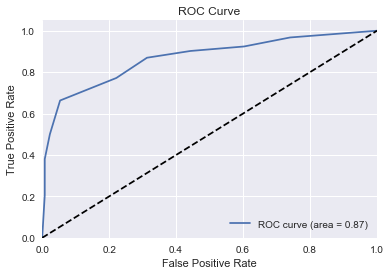

In [171]:
#ROC Curve for Random Forest Classifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
 
# shuffle and split training and test sets
#X_train, X_test, Y_train, Y_test = train_test_split(XX, YY, test_size = 0.20, random_state = 5)
X_train, X_test, Y_train, Y_test = train_test_split(XX, YY, test_size=.25)

forest = RandomForestClassifier()
#clf.set_params(n_estimators = 100, max_depth = 10, max_features = 3, criterion = 'gini')
#rf_clf = clf.fit(X_train,Y_train)
#rf_predict = rf_clf.predict(X_test)

forest.fit(X_train, Y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(Y_test, forest.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

ROC AUC: 0.89


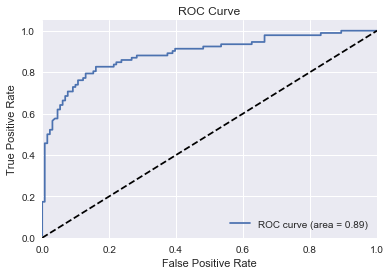

In [172]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(Y_test, model.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

ROC AUC: 0.87


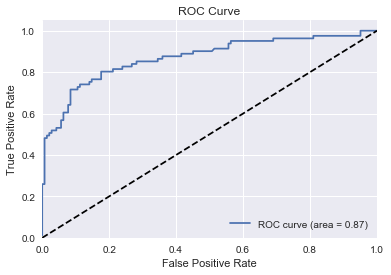

In [176]:
model = GradientBoostingClassifier()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(Y_test, model.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()